In [1]:
import src as gtfs_tool

# Merge

Extracting GTFS zip files and merge the feed into a `TableRepo` object.

**Questions:**
- How to store time data
- What is parent station in stops table - self reference solution

In [2]:
gtfs_tool.merge_feeds()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:28<00:00, 29.34s/it]


# Load graph

Load the merged feed to a `neworkx.MultiDiGraph` object.

In [3]:
graph = gtfs_tool.load_network()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 48308/48308 [43:49<00:00, 18.37it/s]


# Plot nodes

In [16]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from dotenv import load_dotenv
from parquetranger import TableRepo
from src.naming import DATA_DIR, HOUR
from src.meta import Stops, StopTimes
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString

In [9]:
hungary_fp = Path("hungary.geojson")
hungary = gpd.read_file(filename=hungary_fp)

In [10]:
stops_trepo = TableRepo(root_path=DATA_DIR / "stops")
stop_times_trepo = TableRepo(root_path=DATA_DIR / "stop_times")

In [11]:
stops_df = (
    stops_trepo.get_full_df()
    .pipe(
        lambda _df: gpd.GeoDataFrame(
            _df, geometry=gpd.points_from_xy(_df[Stops.stop_lon], _df[Stops.stop_lat])
        )
    )
    .assign(publisher=lambda _df: _df.index.str.split("_").str[-1])
)
stop_times_df = stop_times_trepo.get_full_df()

In [12]:
PUB_COLOR_MAP = {
    "BKV": "purple",
    "MÁV": "darkblue",
    "VOLÁN": "orange",
}

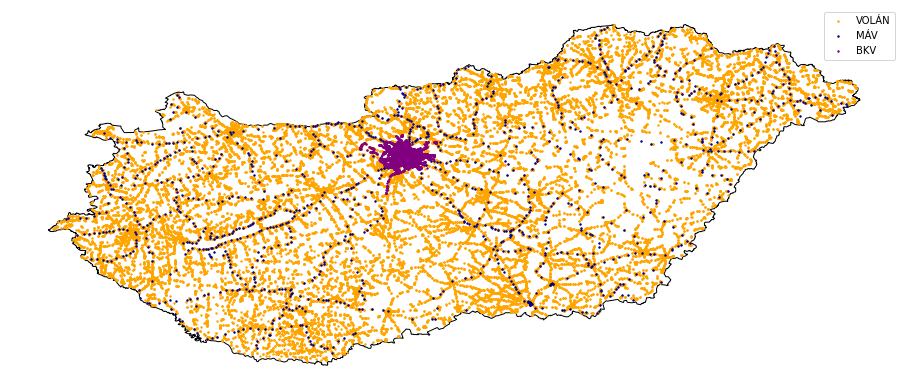

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
hungary.plot(ax=ax, color="white", edgecolor="black")
for publisher, pub_data in stops_df.sort_values("publisher", ascending=False).groupby(
    by="publisher", sort=False
):
    pub_data.plot(ax=ax, color=PUB_COLOR_MAP[publisher], markersize=2, label=publisher)
ax.legend()
plt.axis("off")
plt.savefig("outputs/figures/all_nodes.png")
plt.show()

# Query distance

In [14]:
start = stops_df[lambda _df: _df["stop_name"] == "Pécs"].index[0]
stop = stops_df[lambda _df: _df["stop_name"] == "Sopron"].index[0]

shortest_path = nx.dijkstra_path(graph, start, stop, weight="distance")
len(shortest_path)

20

In [18]:
nx.dijkstra_path_length(graph, start, stop, weight="distance") / HOUR

4.150433161341772

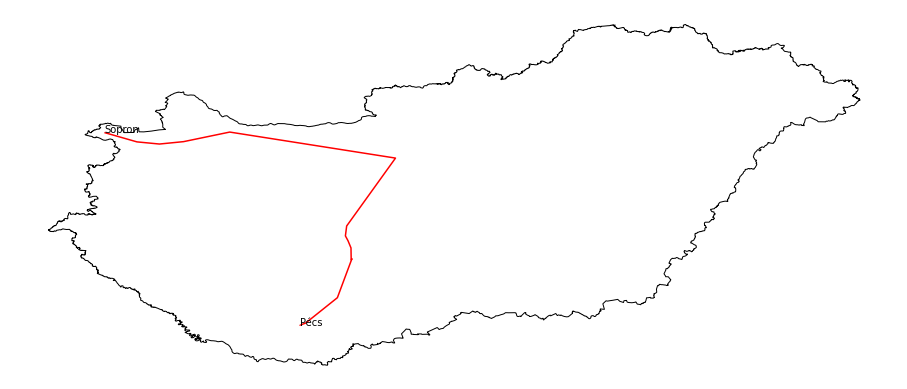

In [60]:
spath = gpd.GeoSeries(
    LineString(
        [
            (graph.nodes[stop]["stop_lon"], graph.nodes[stop]["stop_lat"])
            for stop in shortest_path
        ]
    )
)

fig, ax = plt.subplots(figsize=(16, 16))
hungary.plot(ax=ax, color="white", edgecolor="black")
spath.plot(ax=ax, color="red", markersize=1)

for stop in [shortest_path[0], shortest_path[-1]]:
    ax.annotate(
        text=stops_df.loc[stop, Stops.stop_name],
        xy=stops_df.loc[stop, [Stops.stop_lon, Stops.stop_lat]],
        xycoords="data",
    )

plt.axis("off")
plt.savefig("outputs/figures/path_example.png")
plt.show()